In [1]:
import matplotlib.pyplot as plt

SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
example_file_maxquant = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.maxquant_evidence.aq_reformat.tsv"
ion_file_normed = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.ion_intensities.tsv"
protein_groups_file = "../../test_data/system_tests/organellar_maps/proteinGroups.txt"
directlfq_file = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.protein_intensities.tsv"
evidence_file = "../../test_data/system_tests/organellar_maps/evidence.txt"
evidence_file_annotated = "../../test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv"
aq_reformat_file = "/Users/constantin/workspace/directlfq/test_data/system_tests/organellar_maps/evidence.txt.protgroup_annotated.tsv.maxquant_evidence.aq_reformat.tsv"
image_save_path = "/Users/constantin/workspace/directlfq/test_data/system_tests/organellar_maps/protein_traces/"

In [3]:
import pandas as pd

def find_protid_by_genename(gene2id_dict, gene_name):
    return gene2id_dict.get(gene_name)

def get_gene2id_dict(protein_groups_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t", usecols = ["Protein IDs", "Gene names"])
    #map dict from gene name to list of protein ids
    gene2id_dict = {}
    for index, row in protein_groups_df.iterrows():
        gene = row["Gene names"]
        protid = row["Protein IDs"]
        if gene in gene2id_dict:
            gene2id_dict[gene].append(protid)
        else:
            gene2id_dict[gene] = [protid]

    return gene2id_dict


gene2id_dict = get_gene2id_dict(protein_groups_file)

In [4]:
protid = find_protid_by_genename(gene2id_dict, "AVEN")
print(protid)

['Q9NQS1']


In [5]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import directlfq.visualizations as lfq_viz

import directlfq.utils as lfq_utils


def load_mq_dataframe(example_mq_file):
    mq_df = pd.read_csv(example_mq_file, sep = "\t")
    mq_df = lfq_utils.index_and_log_transform_input_df(mq_df)
    mq_df = mq_df.reindex(sorted(mq_df.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return mq_df

def load_protein_groups_df(protein_groups_file):
    protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")
    protein_groups_df = protein_groups_df.rename(columns = {"Protein IDs" : "protein"})
    protein_groups_df = protein_groups_df.set_index("protein")
    protein_groups_lfq_columns = [x for x in protein_groups_df.columns if x.startswith("LFQ")]
    protein_groups_df_subset = protein_groups_df[protein_groups_lfq_columns]
    protein_groups_df_subset_logged = protein_groups_df_subset.replace(0, np.nan).apply(np.log2)
    protein_groups_df_subset_logged = protein_groups_df_subset_logged.reindex(sorted(protein_groups_df_subset_logged.columns, key= lambda x : get_fraction_number(x)), axis=1)
    protein_groups_df_subset_logged.columns = [x.replace("LFQ intensity ", "") for x in protein_groups_df_subset_logged.columns]
    return protein_groups_df_subset_logged

def load_directlfq_df(directlfq_file):
    directlfq_df = pd.read_csv(directlfq_file, sep = "\t")
    directlfq_df = directlfq_df.drop(columns = ["Gene names", "Protein IDs"])
    directlfq_df = directlfq_df.set_index("protein")
    directlfq_df = directlfq_df.replace(0, np.nan).apply(np.log2)
    directlfq_df = directlfq_df.reindex(sorted(directlfq_df.columns, key= lambda x : get_fraction_number(x)), axis=1)
    return directlfq_df

def filter_df_for_map(df, map):
    #get columns with non-numeric type from a dataframe
    non_numeric_columns = list(df.select_dtypes(exclude=[np.number]).columns)
    map_columns = [x for x in df.columns if map in x and "Cyt" not in x]
    df_shortened = df[map_columns + non_numeric_columns]
    return df_shortened

def get_fraction_number(fraction_name):
    shortened_fraction = fraction_name.split("_")[1].replace("K", "")
    try:
        return int(shortened_fraction)
    except:
        return np.inf

ion_df = load_mq_dataframe(aq_reformat_file)
ion_df_normed = load_mq_dataframe(ion_file_normed)

directlfq_df = load_directlfq_df(directlfq_file)
maxlfq_df = load_protein_groups_df(protein_groups_file)

/var/folders/wb/j08kzzbd2hd8838tn3ll0jfm0000gn/T/ipykernel_57609/4069328298.py:17: DtypeWarning: Columns (221) have mixed types. Specify dtype option on import or set low_memory=False.
  protein_groups_df = pd.read_csv(protein_groups_file, sep = "\t")


In [6]:
import directlfq.protein_intensity_estimation as lfq_protint


def get_protein_profile_matched_to_ions(protein_df, ion_df, selected_prot):
    protein_values = protein_df.loc[[selected_prot]].dropna(axis = 'columns', how = "all").values[0]
    ion_values = ion_df.loc[[selected_prot]].dropna(axis = 'columns', how = "all")
    median_ion_values = np.nanmedian(ion_values, axis = 0)
    return shift_protein_profile_to_median_ion_profile(protein_values, median_ion_values)


def shift_protein_profile_to_median_ion_profile(protein_values, median_ion_values):
    shift = np.nanmedian(protein_values - median_ion_values)
    return protein_values - shift





def compare_maxquant_and_directlfq(ion_df, ion_df_normed, directlfq_df, selected_prot, ax_normed, ax_unnormed):
    colorlist = lfq_viz.AlphaPeptColorMap().colorlist_hex
    color_directlfq = colorlist[0]
    color_mq = colorlist[1]

    protein_df = ion_df.loc[[selected_prot]]
    lfq_viz.IonTraceCompararisonPlotterNoDirectLFQTrace(ion_df, str(selected_prot),ax =ax_unnormed)
    lfq_viz.IonTraceCompararisonPlotterNoDirectLFQTrace(ion_df_normed, str(selected_prot), ax=ax_normed)
    directlfq_values = get_protein_profile_matched_to_ions(directlfq_df, ion_df_normed, selected_prot)
    sns.lineplot(x = range(len(directlfq_values)), y = directlfq_values, ax=ax_normed,color=color_directlfq, linewidth=3, linestyle='-')
    #remove no values from the plot
    lines = ax_normed.get_lines()
    lines[-1].set_label("directLFQ")
    lines[-2].set_label("precursors")
    #get legend handles and labels
    handles, labels = ax_normed.get_legend_handles_labels()
    ax_normed.legend(handles[::-1], labels[::-1], frameon=False)
    ax_unnormed.legend(handles[:-1], labels[:-1], frameon=False)

    #set all y axes to the same limits
    max_y = max(ax_unnormed.get_ylim())
    min_y = min(ax_unnormed.get_ylim())
    ax_unnormed.set_ylabel("log2\nintensity")
    ax_unnormed.set_xlabel("sample")
    ax_normed.set_xlabel("sample")


    

#re order figure along the x axis

Q9NQS1


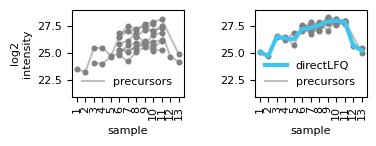

In [7]:
import matplotlib
fig, axes = plt.subplots(1, 2, figsize = (4.05, 1.5))

protid = find_protid_by_genename(gene2id_dict, "AVEN")[0]
print(protid)
compare_maxquant_and_directlfq(ion_df = ion_df, ion_df_normed=ion_df_normed+2, directlfq_df= directlfq_df,selected_prot= protid, ax_unnormed=axes[0],ax_normed=axes[1] )
xticklabels = axes[0].get_xticklabels()
xticklabels = [f"{x+1}" for x in range(len(xticklabels))]
axes[0].set_xticklabels(xticklabels)
axes[1].set_xticklabels(xticklabels)
axes[0].set_ylim(21, 29)
axes[1].set_ylim(21, 29)
#widen space between subplots
plt.subplots_adjust(wspace=2.5)
fig.tight_layout()
fig.savefig(f"{image_save_path}/example_protein_trace.pdf", bbox_inches = "tight", dpi = 300, transparent = True)

